### Converting the model to onnx

In [1]:
import dianna
import tensorflow as tf
import numpy as np
from pathlib import Path
%matplotlib inline
import onnxruntime as ort
from matplotlib import pyplot as plt

2022-09-08 09:49:01.442092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-08 09:49:01.442131: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
loaded_model = tf.keras.models.load_model('test_2018/pre-trained')

2022-09-08 09:44:58.370147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-08 09:44:58.370183: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-08 09:44:58.370199: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyternoteboo): /proc/driver/nvidia/version does not exist
2022-09-08 09:44:58.370402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
savedmodel_dir = 'test_2018/pre-trained'

In [12]:
onnx_savedmodel = 'test_2018/pre-trained.onnx'

In [13]:
!python3 -m tf2onnx.convert --saved-model {savedmodel_dir} --output {onnx_savedmodel} --signature_def serving_default --tag serve

2022-09-07 10:16:55.604079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 10:16:55.604117: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-09-07 10:16:57.245172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-07 10:16:57.245206: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-07 10:16:57.245246: 

### Saving inputs and targets to test

In [2]:
# scratchdir = Path('/scratch/lpalma/')
# experiment_name = 'trial2_ensmean'
# test_inputs = np.load(scratchdir / f'{experiment_name}.testing_inputs.npy')
# test_target = np.load(scratchdir / f'{experiment_name}.testing_terciles.npy')

# np.save('test_2018/test15_inputs', test_inputs[15])
# np.save('test_2018/test15_target', test_target[15])

### DIANNA

In [3]:
train_inputs = np.load('test_2018/train0_inputs.npy')
train_target = np.load('test_2018/train0_target.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


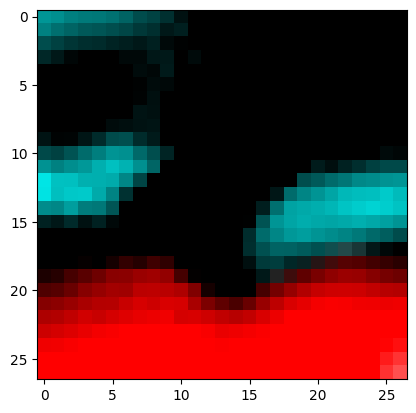

In [4]:
plt.imshow(train_inputs)

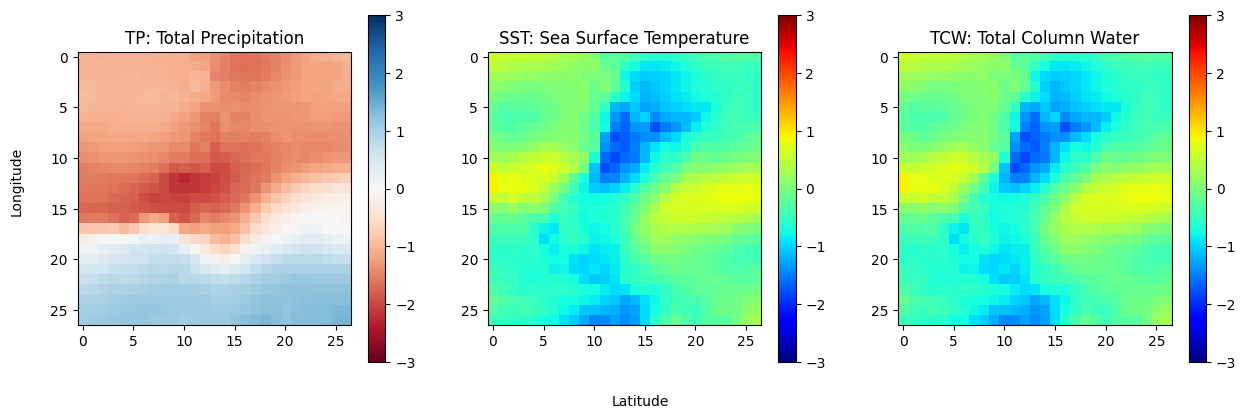

In [5]:
subpl = ['TP: Total Precipitation', 'SST: Sea Surface Temperature', 'TCW: Total Column Water']
cmaps = ['RdBu', 'jet', 'jet']

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

fig.text(0.5, 0.35, 'Latitude', ha='center')
fig.text(0.08, 0.5, 'Longitude', va='center', rotation='vertical')

for col in range(3):
    ax = axs[col]
    tp = ax.imshow(train_inputs[:,:,col], cmap=cmaps[col], vmin = -3, vmax = 3)
    cbar = fig.colorbar(tp, ax = ax, shrink = 0.3)
    ax.title.set_text(subpl[col])

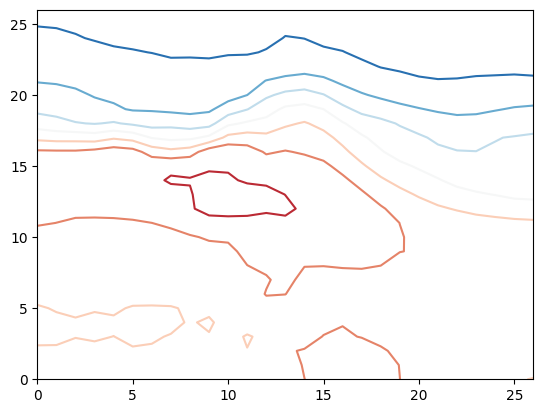

In [228]:
fig, ax = plt.subplots()
CS = ax.contour(train_inputs[:,:,0], cmap = 'RdBu')

In [6]:
model_path = 'test_2018/pre-trained.onnx'

In [204]:
def preprocess_function(image):
    n_classes = 3
    clim_logprobs = generate_climprob_inputs(image, climprobs = np.repeat(1/n_classes, n_classes))
    return [image, clim_logprobs]

In [193]:
sess = ort.InferenceSession(model_path)
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

input_data = preprocess_function(train_inputs)

onnx_input = {}
onnx_input['input_3'] = input_data[1].astype('float32')
onnx_input['input_4'] = input_data[0].astype('float32')        
pred_onnx = sess.run([output_name], onnx_input)[0]

In [205]:
import imp
imp.reload(dianna.methods.rise)
imp.reload(dianna.utils.onnx_runner)
imp.reload(dianna)

<module 'dianna' from '/home/gcrocioni/dianna/dianna/__init__.py'>

In [195]:
from dianna.utils.onnx_runner import SimpleModelRunner
runner = SimpleModelRunner(
    model_path,
    preprocess_function=preprocess_function,
    multiple_inputs=True)

In [196]:
train_in_batch = np.expand_dims(train_inputs, axis=0)
train_in_batch.shape

(1, 27, 27, 3)

In [208]:
train_target.astype('int')

array([1, 0, 0])

In [209]:
relevances = dianna.explain_image(
    model_path,
    train_inputs,
    method="RISE",
    labels=train_target.astype('int'),
    n_masks=5000,
    feature_res=8,
    p_keep=.1,
    axis_labels=('height','width','channels'),
    preprocess_function = preprocess_function,
    multiple_inputs = True)

my RISE


Explaining: 100%|██████████| 50/50 [00:00<00:00, 150.72it/s]


In [211]:
relevances.shape

(3, 27, 27)

In [216]:
import onnxruntime

def run_model(data):
    fname = 'test_2018/pre-trained.onnx'
    # get ONNX predictions
    sess = onnxruntime.InferenceSession(fname)
    output_name = sess.get_outputs()[0].name
    
    onnx_input = {}
    onnx_input['input_3'] = input_data[1].astype('float32')
    onnx_input['input_4'] = input_data[0].astype('float32')
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

In [217]:
run_model(train_inputs)

array([[0.44617072, 0.36250326, 0.19132605]], dtype=float32)

In [218]:
train_target

array([1., 0., 0.], dtype=float32)

In [219]:
class_idx = np.argmax(run_model(train_inputs))
class_idx

0

In [ ]:
subpl = ['TP: Total Precipitation', 'SST: Sea Surface Temperature', 'TCW: Total Column Water']
cmaps = ['RdBu', 'jet', 'jet']

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

fig.text(0.5, 0.35, 'Latitude', ha='center')
fig.text(0.08, 0.5, 'Longitude', va='center', rotation='vertical')

for col in range(3):
    ax = axs[col]
    tp = ax.imshow(train_inputs[:,:,col], cmap=cmaps[col], vmin = -3, vmax = 3)
    cbar = fig.colorbar(tp, ax = ax, shrink = 0.3)
    ax.title.set_text(subpl[col])

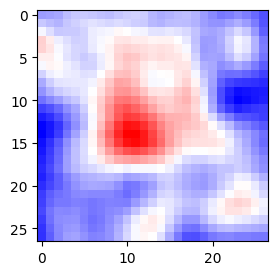

In [234]:
fig = plt.subplots(figsize=(3, 3))
plt.imshow(relevances[class_idx], cmap = 'bwr')

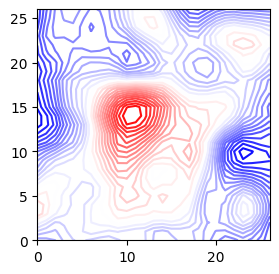

In [238]:
fig, axs = plt.subplots(figsize=(3, 3))
axs.contour(relevances[class_idx], 30, cmap = 'bwr')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


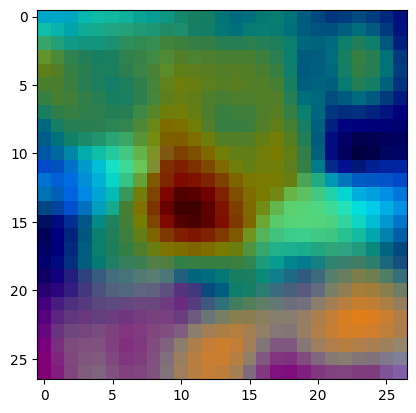

In [221]:
from dianna import visualization

visualization.plot_image(relevances[class_idx], train_inputs, heatmap_cmap='jet')